# Load local files


In [1]:
wv_model_path = "/Users/hyunoochang/code/chyunoo/wineteller/wineteller_v1/preprocessed_data/model.bin"
wine_data_path = "/Users/hyunoochang/code/chyunoo/wineteller/wineteller_v1/preprocessed_data/vectorized_data.csv"

# Define occasion attributes

In [2]:
from scipy import spatial
import numpy as np
import pprint
import matplotlib.pyplot as plt
from matplotlib import gridspec
from math import pi
import pandas as pd
import string
import os
import time
from tqdm import tqdm

from operator import itemgetter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from collections import Counter, OrderedDict

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

model = Word2Vec.load(wv_model_path)
print(model)
word_vectors = model.wv

# we aggregate descriptors that are semantically close with each occasion
# romantic = flowers, fancy = refinement, moody = complex, tertiary aromas such as oak and wood, casual = fruit and medium body
occasion_attributes = {"romantic" : ['violet_rose', 'rose_violet','potpourri', 'rosewater',
                       'lavender', 'lilac', 'rose' 'petal', 'feminine', "flower"],
                       
                       "casual" : ["high_acid","full_bodied", "fruit", "fruit-forward", "medium_bodied", "racy", "tannin"],
                      
                      "moody" : ['wood_age', 'new_wood','oak','oak-driven', 'wood', "vanilla", "brown_butter", "nutty", "maple", "yeast"
                                ],
                      
                      
                      "fancy" : [
                                'refined','elegant',"classy", "opulent", "flashy"
                                  
                                ]}
# retrieve vectors of each word of corpus
wd_vecs = dict()
for wd in word_vectors.index_to_key :
    try:
        wd_vec = word_vectors[wd]
        wd_vecs[wd] = wd_vec
    except:
        continue

# calculate average vector for each occasion attribute and distance with each word of corpus
average_occasion_vecs = dict()
occasion_attributes_distances = dict()
for attribute, keywords in occasion_attributes.items():
    
    all_keyword_vecs = []
    for keyword in keywords:
        try : 
            c_vec = word_vectors[keyword]
            all_keyword_vecs.append(c_vec)
        except : 
            continue
        
    
    avg_attribute_vec = np.average(all_keyword_vecs, axis=0)
    average_occasion_vecs[attribute] = avg_attribute_vec

    attribute_distances = dict()
    for k, v in wd_vecs.items():
        similarity = 1- spatial.distance.cosine(avg_attribute_vec, v)
        attribute_distances[k] = similarity
        
    occasion_attributes_distances[attribute] = attribute_distances   

# store average vector for each occasion attribute and most and least similar word 
occasion_attribute_infos = dict()
for key, value in occasion_attributes.items():
    dict_attribute = dict()
    farthest = min(occasion_attributes_distances[key], key=occasion_attributes_distances[key].get)
    farthest_distance = occasion_attributes_distances[key][farthest]
    closest = max(occasion_attributes_distances[key], key=occasion_attributes_distances[key].get)
    closest_distance = occasion_attributes_distances[key][closest]
    print(key, farthest, closest)
    dict_attribute['farthest'] = farthest_distance
    dict_attribute['closest'] = closest_distance
    dict_attribute['average_vec'] = average_occasion_vecs[key]
    occasion_attribute_infos[key] = dict_attribute

# calculate distance between each occasion vector 
d_romantic = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["romantic"], v)
    d_romantic[a] = distance

d_casual = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["casual"], v)
    d_casual[a] = distance

d_moody = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["moody"], v)
    d_moody[a] = distance 

d_fancy = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["fancy"], v)
    d_fancy[a] = distance

    
d_list = [d_romantic, d_casual, d_moody, d_fancy] 
d_attributes = dict()
for a, d in zip(occasion_attributes.keys(), d_list) : 
    d_attributes[a] = d

pprint.pprint(d_attributes)

# print 10 most similar words with each occasion
sorted_dict = {
    key: dict(sorted(sub_dict.items(), key=lambda item: item[1], reverse=True))
    for key, sub_dict in occasion_attributes_distances.items()
}

for a in occasion_attributes.keys() : 
    print(list(sorted_dict[a].items())[:10])

Word2Vec<vocab=625, vector_size=300, alpha=0.025>
romantic bite lilac
casual walnut medium_bodied
moody prickly wood
fancy hollow refined
{'casual': {'casual': 1,
            'fancy': 0.09507822245359421,
            'moody': -0.06205185130238533,
            'romantic': -0.019163809716701508},
 'fancy': {'casual': 0.09507822245359421,
           'fancy': 1,
           'moody': 0.1957806944847107,
           'romantic': 0.21934109926223755},
 'moody': {'casual': -0.06205185130238533,
           'fancy': 0.1957806944847107,
           'moody': 1,
           'romantic': -0.11601012200117111},
 'romantic': {'casual': -0.019163809716701508,
              'fancy': 0.21934109926223755,
              'moody': -0.11601012200117111,
              'romantic': 1}}
[('lilac', 0.8702071309089661), ('violet_rose', 0.8325842022895813), ('lavender', 0.8246857523918152), ('potpourri', 0.8200422525405884), ('rose_violet', 0.7974104285240173), ('petal', 0.7938634753227234), ('feminine', 0.776771008968353

# Score wines

In [3]:
%%time
# load preprocessed wine dataset
data = pd.read_csv(wine_data_path)
data["review_vector"]=[np.float_(i[2:-2].split()) for i in data["review_vector"]]
data = data[data["descriptor_count"]>0]
print(data["review_vector"][0].shape)

# calculate distance and scaled distance for each wine vector
def minmax_scaler(val, minval, maxval):
    val = max(min(val, maxval), minval)
    normalized_val = (val - minval)/(maxval - minval)
    return normalized_val

def attribute_values(attribute, wine_vector):
    attribute_value = average_occasion_vecs[attribute]
    similarity = 1 - spatial.distance.cosine(attribute_value, wine_vector)
    scaled_similarity = minmax_scaler(similarity, occasion_attribute_infos[attribute]['farthest'], 
                                      occasion_attribute_infos[attribute]['closest'])
    similarity_and_scaled = (similarity, scaled_similarity)
    return similarity_and_scaled

def return_score_values(wine_vector):
    wine_scores = dict()
    for i, wine in enumerate(wine_vector) : 
        attribute_scores = dict()
        for attribute in occasion_attributes.keys():
            attribute_scores[attribute] = attribute_values(attribute, wine)   
        wine_scores[i] = attribute_scores
    return wine_scores

# score each wine with framework
score_values = return_score_values(data["review_vector"])

# create score columns in dataset
romantic = dict()
moody = dict()
casual = dict()
fancy = dict()

for key, values in score_values.items():
    romantic[key] = values["romantic"][-1]
    moody[key] = values["moody"][-1]
    casual[key] = values["casual"][-1]
    fancy[key] = values["fancy"][-1]
    
romantic_dict = dict(zip(romantic.keys(), romantic.values()))
moody_dict = dict(zip(moody.keys(), moody.values()))
casual_dict = dict(zip(casual.keys(), casual.values()))
fancy_dict = dict(zip(fancy.keys(), fancy.values()))

data = data.reset_index()
data["romantic_sc"] = data.index.map(romantic_dict)
data["moody_sc"] = data.index.map(moody_dict)
data["casual_sc"] = data.index.map(casual_dict)
data["fancy_sc"] = data.index.map(fancy_dict)

# discretization of each score (1-4) 
romantic_thresholds = [0,data.romantic_sc.quantile(0.1), data.romantic_sc.quantile(0.7), data.romantic_sc.quantile(0.97),1]
norm_labels = ["1","2","3","4"] 
data["romantic_sc_norm"] = pd.cut(data["romantic_sc"], bins=romantic_thresholds, labels=norm_labels, include_lowest=True)

casual_thresholds = [0,data.casual_sc.quantile(0.02), data.casual_sc.quantile(0.18), data.casual_sc.quantile(0.8),1]
norm_labels = ["1","2","3","4"] 
data["casual_sc_norm"] = pd.cut(data["casual_sc"], bins=casual_thresholds, labels=norm_labels, include_lowest=True)

fancy_thresholds = [0,data.fancy_sc.quantile(0.02), data.fancy_sc.quantile(0.2), data.fancy_sc.quantile(0.8),1]
norm_labels = ["1","2","3","4"] 
data["fancy_sc_norm"] = pd.cut(data["fancy_sc"], bins=fancy_thresholds, labels=norm_labels, include_lowest=True)

moody_thresholds = [0,data.moody_sc.quantile(0.05), data.moody_sc.quantile(0.4), data.moody_sc.quantile(0.95),1]
norm_labels = ["1","2","3","4"] 
data["moody_sc_norm"] = pd.cut(data["moody_sc"], bins=moody_thresholds, labels=norm_labels, include_lowest=True)

data.moody_sc_norm = data.moody_sc_norm.astype(int)
data.romantic_sc_norm = data.romantic_sc_norm.astype(int)
data.fancy_sc_norm = data.fancy_sc_norm.astype(int)
data.casual_sc_norm = data.casual_sc_norm.astype(int)

(300,)
CPU times: user 36 s, sys: 2.2 s, total: 38.2 s
Wall time: 41.7 s


# Pair occasion input with model

{'romantic_sc_norm': 2, 'moody_sc_norm': 1, 'fancy_sc_norm': 4, 'casual_sc_norm': 2}
(0, 17)
no wine matched found, using average of input
       romantic_sc  moody_sc  casual_sc  fancy_sc
33541     0.198194  0.749494   0.464425  0.718240
64463     0.140172  0.753185   0.357390  0.717414
71977     0.185992  0.353003   0.770240  0.716002
28561     0.214065  0.705470   0.468421  0.713469


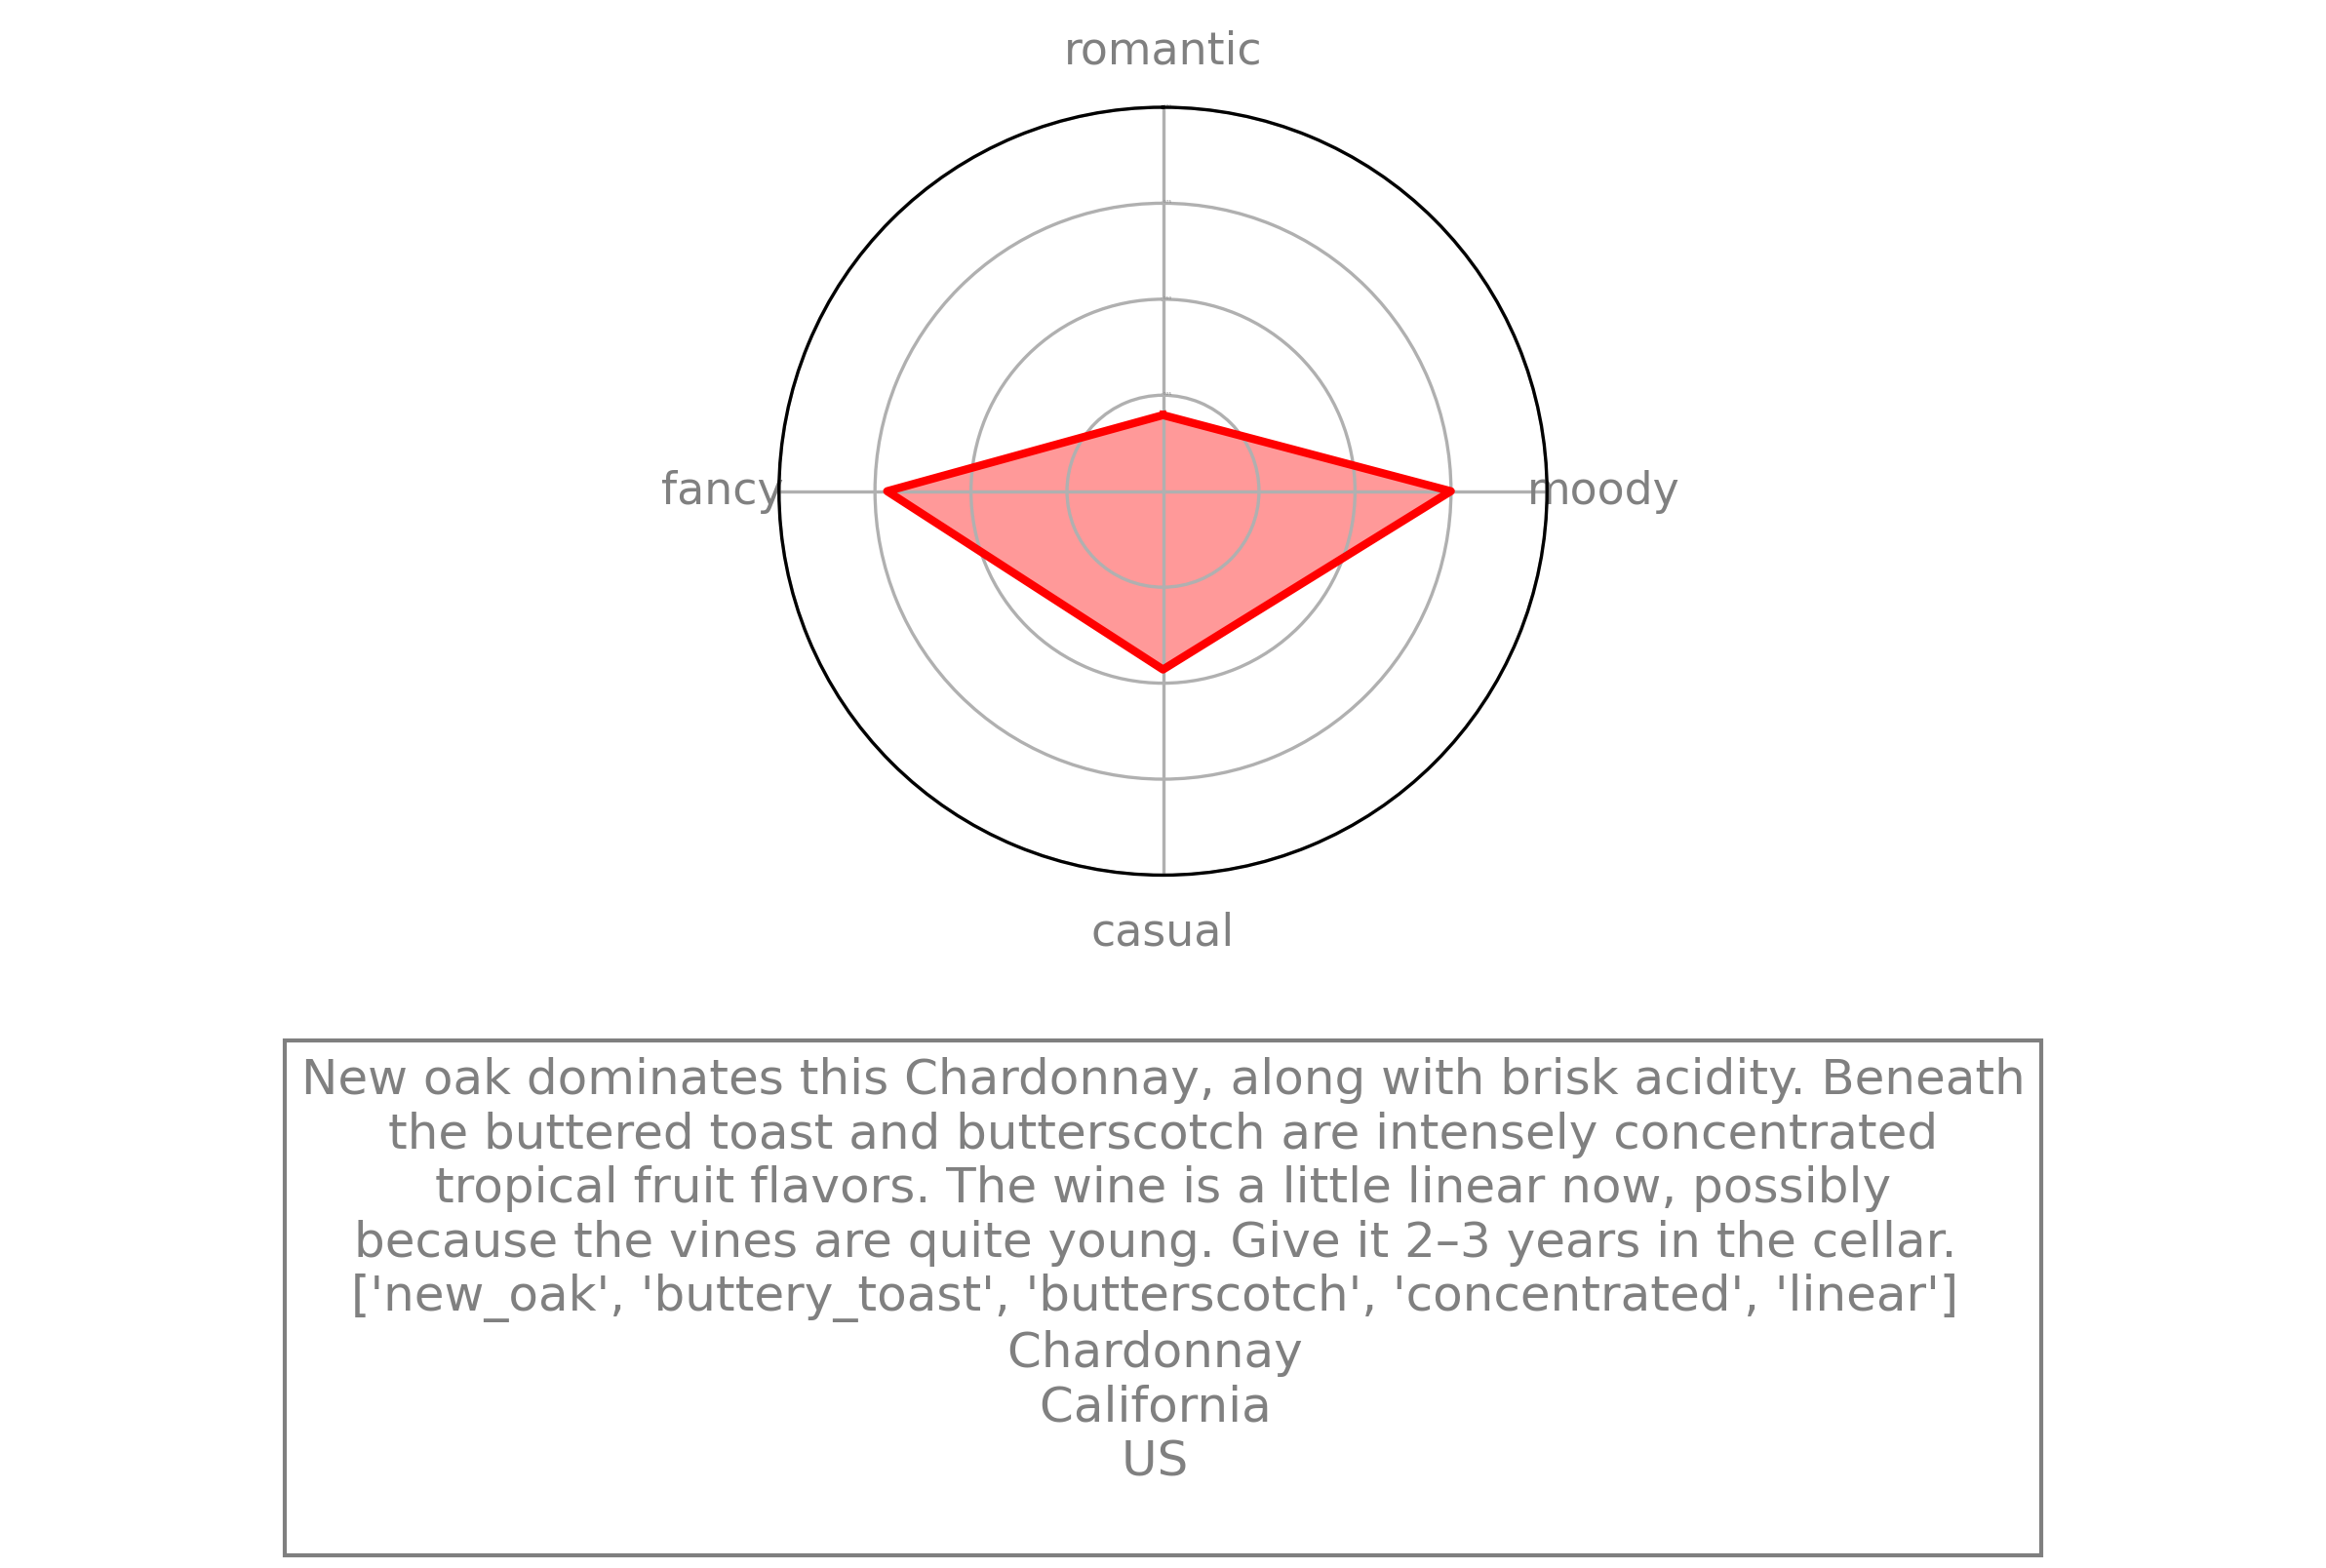

In [4]:
import random
import textwrap

# define plotting functions
def make_spider(gs, n,c, data, title, color):
    
    categories = list(occasion_attributes.keys())
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(gs[n,c], polar=True,)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=11)

    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25","0.50","0.75", "1.00"], color="grey", size=0)
    plt.ylim(0, 1)

    values = list(data.values())
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

def plot_wine_recommendations(pairing_wines, pairing_occasion_attributes, pairing_description): 

    subplot_rows = 2
    subplot_columns = len(pairing_wines)
    fig = plt.figure(figsize=(10, 5), dpi=300)
    fig_height, fig_width = fig.get_size_inches()

    gs = gridspec.GridSpec(subplot_rows, subplot_columns, height_ratios=[3,1]) 
    
    n = 0 
    r = 1
    c = 0

    for w in range(len(pairing_wines)):
        make_spider(gs, n,c, pairing_occasion_attributes[w], pairing_wines[w], 'red')
        create_text(gs, r,c,pairing_description[w])
        c += 1
            
def create_text(gs, r,c, description):
    
    ax = plt.subplot(gs[r,c])
    text_content = ""
    
    for i in range(len(description)) : 
        main_description = description[i]
        lines = textwrap.wrap(main_description)
        wrapped_text = '\n'.join(lines)
        text_content += f"{wrapped_text} \n"
        
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    
    ax.text(x=0.5, y=-0.25, s=text_content, fontsize=12, color='grey',
         horizontalalignment='center',verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

# Instate random user input 
random_input = [random.randint(1, 4) for i in range(4)]
input_occasion = dict()
input_labels = ["romantic_input", "moody_input", "casual_input", "fancy_input"]
for i,j  in zip(input_labels, random_input) : 
    input_occasion[i] = j
input_occasion["romantic_sc_norm"] = input_occasion.pop('romantic_input')
input_occasion["moody_sc_norm"] = input_occasion.pop('moody_input')
input_occasion["fancy_sc_norm"] = input_occasion.pop('fancy_input')
input_occasion["casual_sc_norm"] = input_occasion.pop('casual_input')
print(input_occasion)

# Filter wines based on input scores
filtered = data.loc[(data["romantic_sc_norm"] == input_occasion["romantic_sc_norm"]) & 
         (data["moody_sc_norm"] == input_occasion["moody_sc_norm"]) & 
        (data["fancy_sc_norm"] == input_occasion["fancy_sc_norm"]) & 
        (data["casual_sc_norm"] == input_occasion["casual_sc_norm"])]
print(filtered.shape)

# If at least 1 wine is found, shuffle and return max 4 wines
try : 
    final_selection = filtered.sample(4)
# If there are no wines with matching scores, calculate average input score and return similar wines
except ValueError :
    if len(filtered) == 0 : 
        print("no wine matched found, using average of input")
        input_occasion_values = [i for i in input_occasion.values()]
        input_average = np.mean(input_occasion_values)
        # Input value
        input_value = input_average
        data["avg_sc"] = data[["romantic_sc_norm", "fancy_sc_norm", "moody_sc_norm", "casual_sc_norm"]].mean(axis=1)
        # Calculate absolute differences
        data['abs_diff'] = abs(data['avg_sc'] - input_value)
        # Find the row with the minimum absolute difference
        closest_row = data.loc[data['abs_diff'].idxmin()]
        # Filter the DataFrame for the closest row(s)
        closest_rows = data[data['abs_diff'] == closest_row['abs_diff']]
        default_key = 'casual_sc'
        # Sort the dictionary items based on values
        sorted_items = sorted(input_occasion.items(), key=lambda x: x[1], reverse=True)
        max_value = sorted_items[0][1]
        # Check if there are multiple maximum values
        multiple_max_values = [key for key, value in sorted_items if value == max_value]
        # If there are multiple maximum values, always return wines with highest casual score
        if len(multiple_max_values) > 1:
            max_pair = (default_key, max_value)
        else:
            max_pair = sorted_items[0]
        # Slice the string up to the index of the special character
        input_highest_sc = max_pair[0]
        index = input_highest_sc.index("sc")
        input_highest_sc = input_highest_sc[:index+2]
        final_selection = closest_rows.sort_values(input_highest_sc, ascending=False)[:4]
    else : 
        final_selection = filtered
        
desired_order_list = ["romantic", "moody", "casual", "fancy"]
occasion_attributes = {k: occasion_attributes[k] for k in desired_order_list}

# Retrieve descriptive data of each recommendation 
pairing_id = list(final_selection.index)
occasion_scores = data.loc[pairing_id, ["romantic_sc", "moody_sc", "casual_sc", "fancy_sc"]]
pairing_occasion_attributes = occasion_scores[["romantic_sc", "moody_sc", "casual_sc", "fancy_sc"]].to_dict('records')
pairing_description = list(data.loc[pairing_id, ["description"]].description)
print(occasion_scores)
descriptors = list(data.loc[pairing_id, ["normalized_descriptors"]].normalized_descriptors)
varieties = list(data.loc[pairing_id, ["variety"]].variety)
provinces = list(data.loc[pairing_id, ["province"]].province)
countries = list(data.loc[pairing_id, ["country"]].country)
all_description = [[pairing_description[i],descriptors[i], varieties[i], provinces[i], countries[i]] for i in range(len(descriptors))]

# Print 1 wine
plot_wine_recommendations([pairing_id[0]], [pairing_occasion_attributes[0]],[all_description[0]])